In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py
import xarray as xr
import scipy.signal as ss
import scipy.optimize as opt

# Candidates

In [58]:
cand = np.loadtxt('/hdd/data/candidates/T2/cluster_output1706174141.cand', unpack=True)
cand.shape

(12, 38)

In [2]:
cands = pd.read_csv('/hdd/data/candidates/T2/cluster_output.csv')

In [3]:
cands

snr        if    specnum       mjds  ibox  idm        dm  ibeam  \
0        11.0155   2481513    9918424    325.257   256    0    2.0000      0   
1        13.7119   2483679    9927088    325.541   256  205   65.6063      0   
2        11.4509   2488075    9944672    326.117   256  343  111.3700      0   
3        11.8971   2481471    9918256    325.251   128   63   21.2717      0   
4        11.3547   2481423    9918064    325.245   128   74   24.6500      0   
...          ...       ...        ...        ...   ...  ...       ...    ...   
1014213  10.0373  97141961  388560216  12732.600   128  350  113.7960      0   
1014214  10.8447  97141813  388559624  12732.600   256  359  116.9320      0   
1014215  10.5958  97141797  388559560  12732.600   256  363  118.3320      0   
1014216  12.1200  97141795  388559552  12732.600   256  364  118.6830      0   
1014217  12.1269  97141735  388559312  12732.600   256  386  126.4630      0   

         cl  cntc  cntb  trigger  
0         1    76     1        0  
1         3   181     1        0  
2         4   131     1        0  
3         5     9     1        0  
4         6    79     1        0  
...      ..   ...   ...      ...  
1014213  -1   734     1        0  
1014214  -1   734     1        0  
1014215  -1   734     1        0  
1014216  -1   734     1        0  
1014217  -1   734     1        0  

[1014218 rows x 12 columns]

(2659.17, 2659.27)

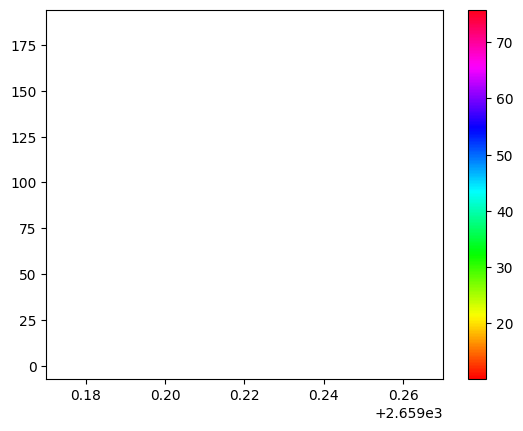

In [4]:
#want = cands["mjds"]<4000
#want = (cands["snr"]<50) & (cands["mjds"]<4000)
plt.scatter(cands["mjds"], cands["dm"], s=1, c=cands["snr"], cmap=plt.cm.hsv)
plt.colorbar()
plt.xlim(2659.17,2659.27)


(2000.0, 2500.0)

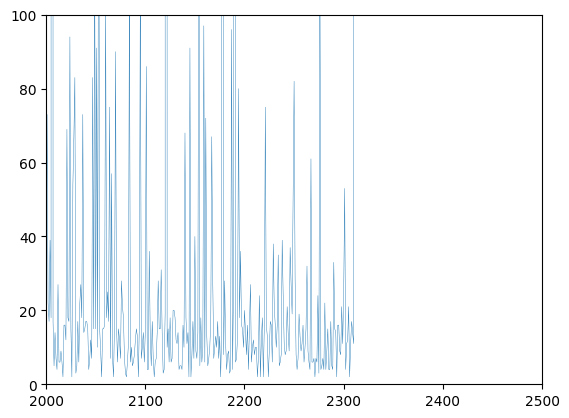

In [55]:
plt.plot(cands["cntc"], lw=0.3)
# plt.ylim(0,100)
# plt.xlim(2000, 2500)

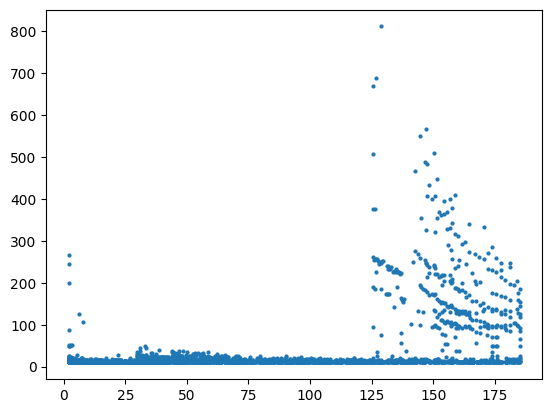

In [86]:
plt.plot(cands["dm"], cands["snr"], 'o', ms=2)
#plt.xlim(13,50)
#plt.ylim(9,20)

# Voltage data

In [76]:
#vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240215T034728.nc')
vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240225T191549.nc') # requant = 8

dt = (vol.time.max() - vol.time.min()) * 24 * 3600
#dt = (np.sort(vol.time)[-2] - vol.time.min()) * 24 * 3600
print('time span of the voltage file is {:.2f} s'.format(dt)) # seconds
vol

time span of the voltage file is 4.29 s


<xarray.Dataset>
Dimensions:   (time: 524288, pol: 2, freq: 2048, reim: 2)
Coordinates:
  * time      (time) float64 8.821e+03 8.821e+03 ... 8.821e+03 8.821e+03
  * pol       (pol) <U1 'a' 'b'
  * freq      (freq) float64 1.53e+03 1.53e+03 1.53e+03 ... 1.28e+03 1.28e+03
  * reim      (reim) <U9 'real' 'imaginary'
Data variables:
    voltages  (time, pol, freq, reim) int8 ...

In [14]:
# examine voltage 

In [77]:
### calculate Stokes I 
stokesi = np.square(abs(vol), dtype='int32').sum(dim='pol', dtype='int32').sum(dim='reim', dtype='int32')
vmax = np.mean(stokesi.voltages) + 2*np.std(stokesi.voltages)
stokesi

<xarray.Dataset>
Dimensions:   (time: 524288, freq: 2048)
Coordinates:
  * time      (time) float64 8.821e+03 8.821e+03 ... 8.821e+03 8.821e+03
  * freq      (freq) float64 1.53e+03 1.53e+03 1.53e+03 ... 1.28e+03 1.28e+03
Data variables:
    voltages  (time, freq) int32 0 27 34 10 14 37 23 9 ... 43 50 62 9 6 21 15 55

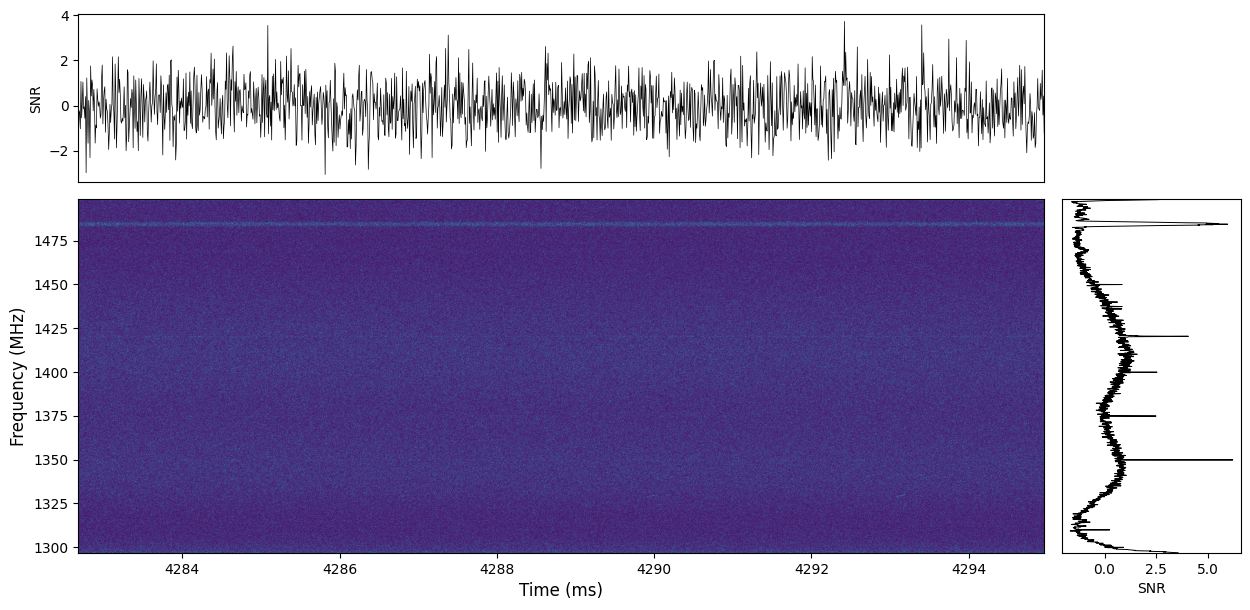

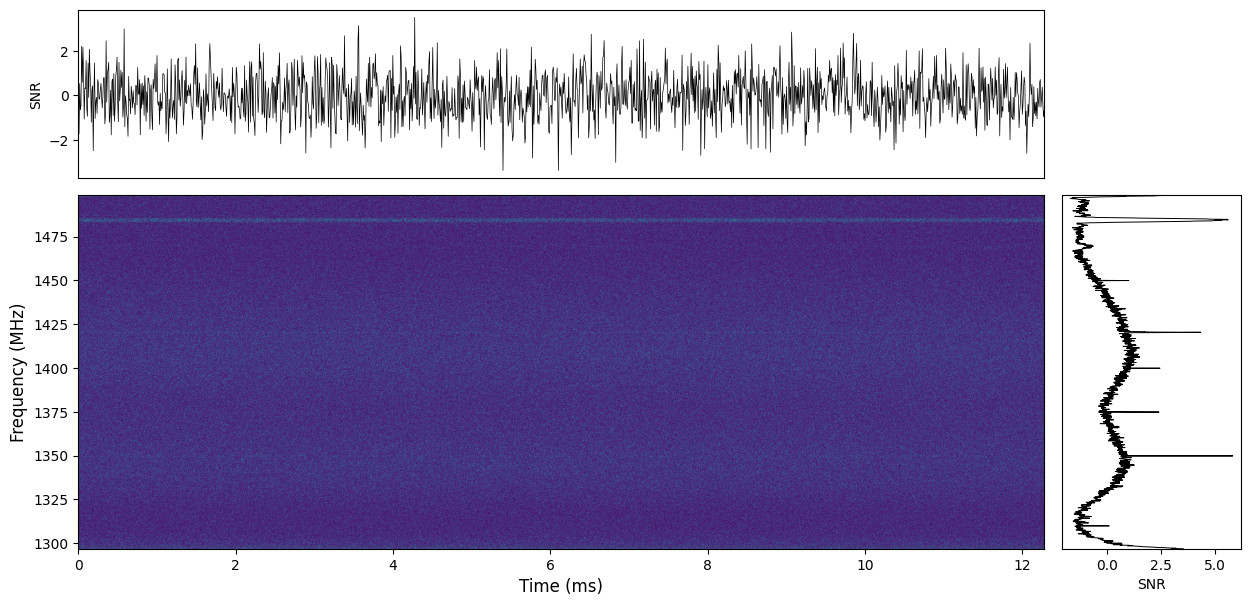

In [78]:
### faster
# plot 1500 time samples at a time (~ 12ms)
N = 0
# which chunk of time to plot (starting from 1)
ti_start = int((N-1)*1500)
ti_end   = ti_start+1500
t_start = stokesi.time[ti_start]
t_end   = stokesi.time[ti_end-1]
t0 = (t_start - stokesi.time[0])*86400*1e3 
Dt = (t_end-t_start) * 86400 * 1e3 #milli seconds
data = stokesi.isel(time=np.arange(ti_start, ti_end), freq=np.arange(255, 1910)).voltages
vmax_N = data.max()
if vmax_N < vmax:
    vmax = vmax_N
plt.figure(figsize=(15,7))
grid = plt.GridSpec(3, 6, wspace=0.1, hspace=0.1)
plt.subplot(grid[0, :5])
data_favg = data.mean(dim='freq')
plt.plot(data.time, (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
# plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.xlim(data.time.min(), data.time.max())
plt.xticks([], [])
plt.subplot(grid[1:, :5])
plt.imshow(data.T, aspect='auto', vmax=vmax,  extent=(t0, Dt+t0, data.freq.min(), data.freq.max()))
#plt.xlim(1966, 1967)
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Frequency (MHz)', fontsize=12)
plt.subplot(grid[1:, 5])
data_tavg = data.mean(dim='time')
plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), data.freq, lw=0.7, color='black')# plt.xlabel('Frequency (MHz)')
# plt.ylabel('SNR')
plt.xlabel('SNR')
plt.ylim(data.freq.min(), data.freq.max())
plt.yticks([], []);
plt.show()

N=N+1
ti_start = int((N-1)*1500)
ti_end   = ti_start+1500
t_start = stokesi.time[ti_start]
t_end   = stokesi.time[ti_end-1]
t0 = (t_start - stokesi.time[0])*86400*1e3 
Dt = (t_end-t_start) * 86400 * 1e3 #milli seconds
data = stokesi.isel(time=np.arange(ti_start, ti_end), freq=np.arange(255, 1910)).voltages
vmax_N = data.max()
if vmax_N < vmax:
    vmax = vmax_N
plt.figure(figsize=(15,7))
grid = plt.GridSpec(3, 6, wspace=0.1, hspace=0.1)
plt.subplot(grid[0, :5])
data_favg = data.mean(dim='freq')
plt.plot(data.time, (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
# plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.xlim(data.time.min(), data.time.max())
plt.xticks([], [])
plt.subplot(grid[1:, :5])
plt.imshow(data.T, aspect='auto', vmax=vmax,  extent=(t0, Dt+t0, data.freq.min(), data.freq.max()))
#plt.xlim(1966, 1967)
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Frequency (MHz)', fontsize=12)
plt.subplot(grid[1:, 5])
data_tavg = data.mean(dim='time')
plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), data.freq, lw=0.7, color='black')# plt.xlabel('Frequency (MHz)')
# plt.ylabel('SNR')
plt.xlabel('SNR')
plt.ylim(data.freq.min(), data.freq.max())
plt.yticks([], []);
plt.show()

In [80]:
### collapse freq - see any short time spikes in the spectrum... 

stokesi_favg = stokesi.isel(freq=np.arange(255, 1910)).voltages.mean(dim='freq')
stokesi_snr = (stokesi_favg - stokesi_favg.mean(dim='time')) / np.std(stokesi_favg)
want = abs(stokesi_snr)>7.
print(len(np.where(want==True)[0]))
stokesi_snr


371


<xarray.DataArray 'voltages' (time: 524288)>
array([ 0.29731264, -0.52513967,  0.13523327, ..., -0.14070349,
        0.10978279, -0.37645529])
Coordinates:
  * time     (time) float64 8.821e+03 8.821e+03 ... 8.821e+03 8.821e+03

Text(0, 0.5, 'Frequency (MHz)')

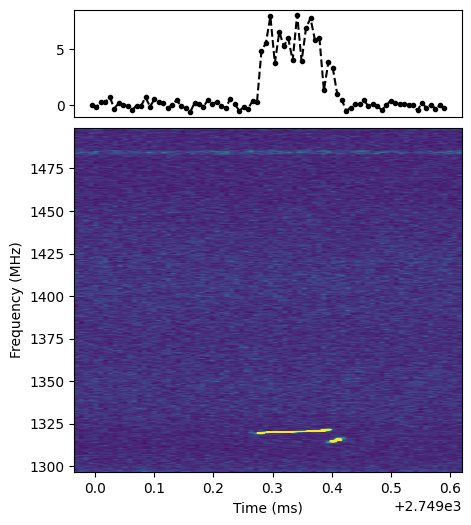

In [81]:
n = 0
i = np.where(want==True)[0][n] # time index
t_i = 40
t0 = (stokesi.isel(time=(i-t_i)).time - stokesi.time[0]) * 86400*1e3 # starting time in ms
Dt = (stokesi.isel(time=(i+t_i)).time - stokesi.isel(time=(i-t_i)).time) * 86400 * 1e3 # duration of the plot in ms
data = stokesi.isel(time=np.arange(i-t_i, i+t_i), freq=np.arange(255, 1910)).voltages # plot +- 0.8ms
snr = stokesi_snr.isel(time=np.arange(i-t_i, i+t_i))
plt.figure(figsize=(5,6))
grid = plt.GridSpec(4, 1, wspace=0.1, hspace=0.1)
# make subplots
plt.subplot(grid[0, 0])
plt.plot(snr, 'o--', ms=3, color='black')
plt.xticks([], [])
plt.subplot(grid[1:,0])
plt.imshow(data.T, aspect='auto', vmax=vmax, extent=(t0, t0+Dt, data.freq.min(), data.freq.max()))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
#plt.ylim(1310, 1325)
#plt.ylim(1346, 1353)
#plt.colorbar()

In [20]:
np.where(want==True)[0][4]

82683

In [49]:
(4.8e-10**2/np.pi*9.1e-28*3e10) / 1.4e9**3 *1e6 * 1e18

7.2964421257476275e-40

In [50]:
np.pi*9.1e-28*3e10 / 4.8e-10**2 

372.24600452691567

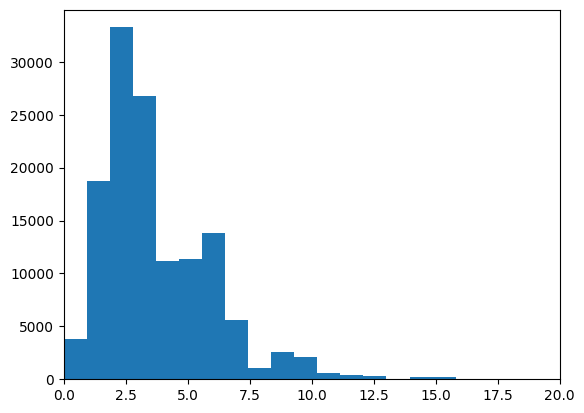

In [38]:
plt.hist(data.values.ravel(), bins=400)
plt.xlim(0, 20);

In [ ]:
# should be an exponential, understand why some values are missing
# understand from voltage gaussian 
# 1. eliminated RFI channel --> see distribution

Text(0, 0.5, 'Frequency (MHz)')

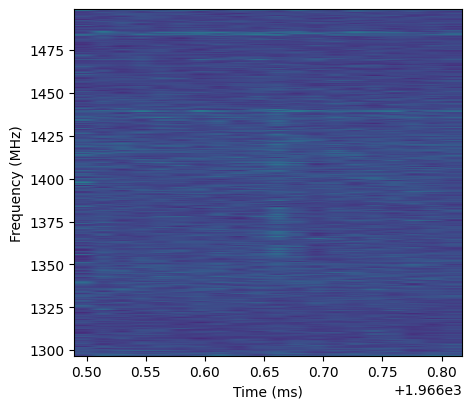

In [12]:
### Could further downsample to visualize it better?
plt.figure(figsize=(5,4.5))
plt.imshow(ss.decimate(data.values, 2, axis=0).T, aspect='auto', vmax=vmax, extent=(t0, t0+Dt, data.freq.min(), data.freq.max()))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')

# RFI flag

In [147]:
# vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240215T034728.nc') # requant = 10 with significant RFI
# vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240225T191549.nc') # requant = 8
vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240212T041511.nc') # requan = 5; with p.33 RFI
dt = (vol.time.max() - vol.time.min()) * 24 * 3600
print('time span of the voltage file is {:.2f} s'.format(dt)) # seconds
# calculate stokes I only from 1300 to 1500 MHz
# pick a time chunk for faster tests
#stokesi = np.square(abs(vol.isel(time=np.arange(82683-2000, 82683+2000), freq=np.arange(255, 1910))), dtype='int32').sum(dim='pol', dtype='int32').sum(dim='reim', dtype='int32')
stokesi = np.square(abs(vol.isel(time=np.arange(264810, 268810), freq=np.arange(255, 1910))), dtype='float32').sum(dim='pol', dtype='float32').sum(dim='reim', dtype='float32')
#stokesi = stokesi.to_dataarray()
#stokesi = np.square(abs(vol.isel(freq=np.arange(255, 1910))), dtype='int32').sum(dim='pol', dtype='int32').sum(dim='reim', dtype='int32')
vmax = np.mean(stokesi.voltages) + 2*np.std(stokesi.voltages)
collap_t = stokesi.mean(dim='time')
dt = (stokesi.time.max().values - stokesi.time.min().values)*86400*1e3 # ms
t0 = (stokesi.time.min() - vol.time.min())*86400*1e3 # ms

time span of the voltage file is 4.29 s


In [2]:
### baseline fitting + threshold
# baseline fitting
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

def Mask(data_stokesI, threshold_f, threshold_t, plot=False, plot_vmax=False, return_mask = 0, baseline=False, outputpng=False):
    """
    masks stokes I data based on the given threshold;
    modifies the input data directly;
    returns a mask file.
    ----------
    return_mask = 0: total mask file; 1: frequency mask file and time mask file separately
    """
    ### frequency masking
    # collapse spectra along time axis
    collapse_t = data_stokesI.mean(dim='time')
    
    base = baseline_als(collapse_t.voltages, 400, 0.001)
    thrsh_u = threshold_f * np.std(collapse_t.voltages).values + base # frequency threshold upper
    thrsh_d =-threshold_f * np.std(collapse_t.voltages).values + base # lower

    # find which freq channels exceed the threshold
    mask_fid = np.where((collapse_t.voltages > thrsh_u)|(collapse_t.voltages < thrsh_d))[0]
    mask_fmap = np.ones_like(collapse_t.voltages)
    
    # create a mask file (ones and zeros) and mask the original data (baseline)
    for id in mask_fid:
        mask_fmap[id] = 0
        data_stokesI['voltages'][:,id] = base[id]
    # convert to a 2D mask map
    mask_fmap = np.tile(mask_fmap, (data_stokesI.voltages.shape[0],1))
    if baseline==True:
        data_stokesI['voltages'] = data_stokesI['voltages']/base

    ### time masking
    collapse_f = data_stokesI.mean(dim='freq')
    collapse_f_snr = (collapse_f.voltages - collapse_f.voltages.mean(dim='time')) / np.std(collapse_f.voltages)
    mean = collapse_f.voltages.mean(dim='time') # for replacement
    print(mean)
    # mean.values = 15.24
    thrsh_t = threshold_t # snr threshold for t
    mask_tid = np.where(abs(collapse_f_snr)>thrsh_t)[0]
    mask_tmap = np.ones_like(collapse_f.voltages)
    for id in mask_tid:
        mask_tmap[id] = 0
        data_stokesI['voltages'][id,:] = mean
    
    mask_tmap = np.tile(mask_tmap, (data_stokesI.voltages.shape[1], 1)).T

    MASK = mask_tmap * mask_fmap
    
    if plot==True:
        vmax = np.mean(data_stokesI.voltages) + 2*np.std(data_stokesI.voltages)
        dt = (data_stokesI.time.max().values - data_stokesI.time.min().values)*86400*1e3 # ms
        plt.figure(figsize=(12,5))
        grid = plt.GridSpec(4, 8, wspace=0.1, hspace=0.1)
        
        plt.subplot(grid[1:, :3])
        if plot_vmax==True:
            plt.imshow(data_stokesI.voltages.T, 
                       vmax=vmax, aspect='auto', 
                       extent=(t0, dt+t0, data_stokesI.freq.min(), data_stokesI.freq.max()))
        else:
            plt.imshow(data_stokesI.voltages.T, 
                       aspect='auto', 
                       extent=(t0, dt+t0, data_stokesI.freq.min(), data_stokesI.freq.max()))
        #plt.colorbar()
        plt.xlabel('Time (ms)', fontsize=12)
        plt.ylabel('Frequency (MHz)', fontsize=12)
        
        plt.subplot(grid[1:, 3])
        data_tavg = data_stokesI.mean(dim='time').voltages
        plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), data_stokesI.freq, lw=0.7, color='black')
        plt.xlabel('SNR')
        plt.ylim(stokesi.freq.min(), stokesi.freq.max())
        plt.yticks([], [])
        
        plt.subplot(grid[0, :3])
        data_favg = data_stokesI.mean(dim='freq').voltages
        plt.plot(data_stokesI.time, (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
        plt.ylabel('SNR')
        plt.xlim(data_stokesI.time.min(), data_stokesI.time.max())
        plt.xticks([], [])
        
        plt.subplot(grid[1:, 5:])
        plt.imshow(MASK.T, aspect='auto', 
                   extent=(t0, dt+t0, data_stokesI.freq.min(), data_stokesI.freq.max()))
        plt.colorbar()
        plt.xlabel('Time (ms)', fontsize=12)
        plt.ylabel('Frequency (MHz)', fontsize=12)
        if outputpng!=False:
            plt.savefig(outputpng, dpi=600)
        plt.show();

    if return_mask == 0:
        return(MASK)
    elif return_mask == 1:
        return(mask_fmap, mask_tmap)
    else:
        print('Not a valid return_mask')


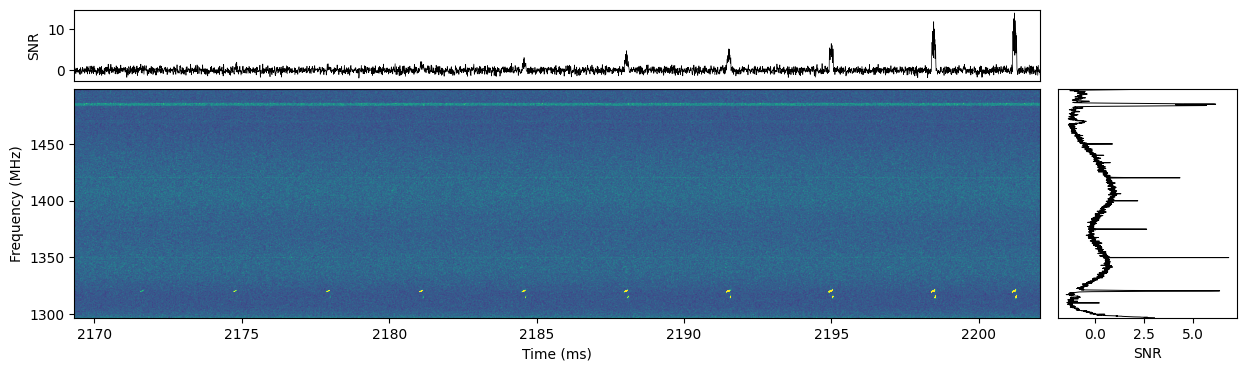

In [149]:
plt.figure(figsize=(15,4))
grid = plt.GridSpec(4, 6, wspace=0.1, hspace=0.1)

plt.subplot(grid[0, :5])
data_favg = stokesi.mean(dim='freq').voltages
plt.plot(stokesi.time, (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
# plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.xlim(stokesi.time.min(), stokesi.time.max())
plt.xticks([], [])

plt.subplot(grid[1:, :5])
vmax = np.mean(stokesi.voltages) + 2*np.std(stokesi.voltages)
plt.imshow(stokesi.voltages.T, vmax=vmax, aspect='auto', extent=(t0, dt+t0, stokesi.freq.min(), stokesi.freq.max()))
#plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.subplot(grid[1:, 5])
data_tavg = stokesi.mean(dim='time').voltages
plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), stokesi.freq, lw=0.7, color='black')# plt.xlabel('Frequency (MHz)')
# plt.ylabel('SNR')
plt.xlabel('SNR')
plt.ylim(stokesi.freq.min(), stokesi.freq.max())
plt.yticks([], []);

<xarray.DataArray 'voltages' ()>
array(1.02704151)


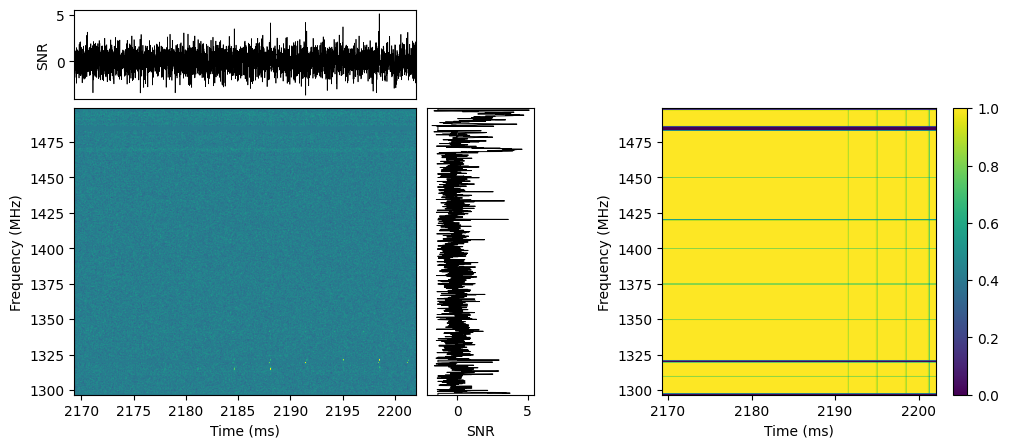

In [150]:
mask = Mask(stokesi, 1, 5, plot=True, plot_vmax=True, baseline=True)

### Mask time bins

In [10]:
data_test = stokesi.copy()
collapse_f = stokesi.mean(dim='freq')
collapse_f_snr = (collapse_f.voltages - collapse_f.voltages.mean(dim='time')) / np.std(collapse_f.voltages)
mean = collapse_f.voltages.mean(dim='time') # for replacement
mean.values = 15.24
thrsh_t = 3 # snr
mask_tid = np.where(abs(collapse_f_snr)>thrsh_t)[0]
mask_tmap = np.ones_like(collapse_f.voltages)
print(mean)
for id in mask_tid:
    mask_tmap[id] = 0
    data_test['voltages'][id,:] = mean.round()

mask_tmap = np.tile(mask_tmap, (data_test.voltages.shape[1], 1)).T

<xarray.DataArray 'voltages' ()>
array(15.24)


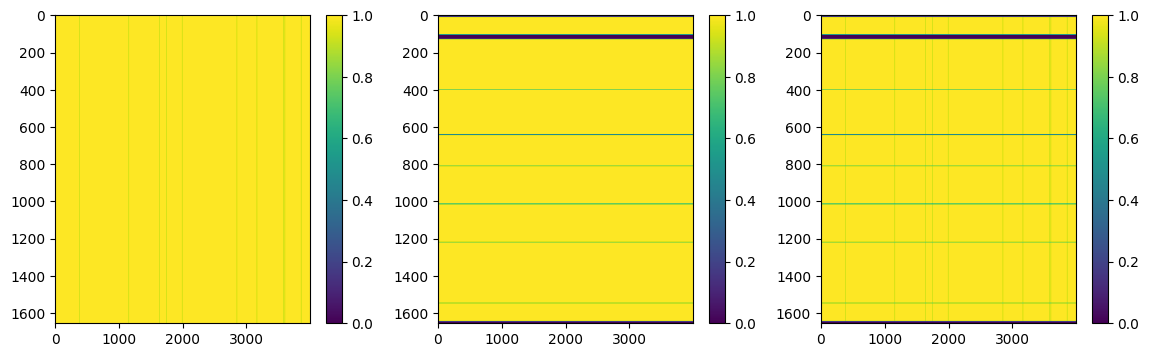

In [34]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(mask_tmap.T, aspect='auto')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(mask.T, aspect='auto')
plt.colorbar()
plt.subplot(1,3,3)
MASK = mask_tmap*mask
plt.imshow(MASK.T, aspect='auto')
plt.colorbar()
# plt.xlim(1000, 1300)
# plt.ylim(660,620)

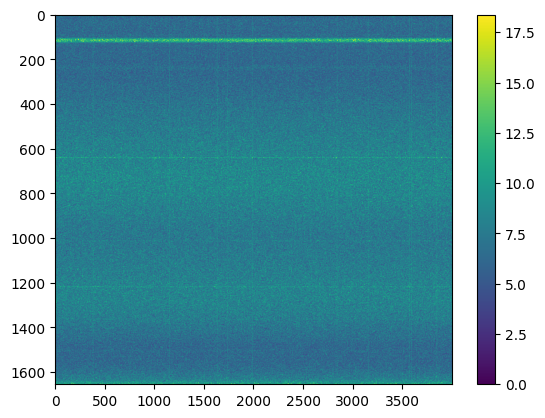

In [19]:
vmax = np.mean(data_test.voltages) + 2*np.std(data_test.voltages)
plt.imshow(data_test.voltages.T, aspect='auto',vmax=vmax)
plt.colorbar()

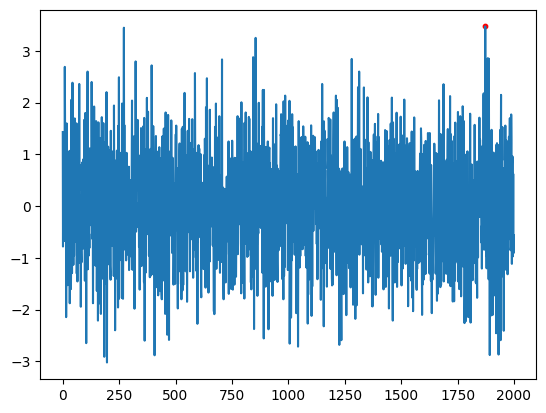

In [60]:
plt.plot(collapse_f_snr)
plt.scatter(flag_t[3], collapse_f_snr[flag_t[3]], s=10, color='red')

### Baseline fitting + mask

In [5]:
# baseline fitting
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

(1655,)


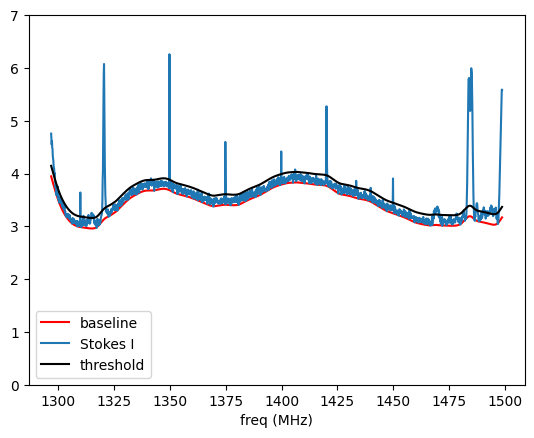

In [7]:
base = baseline_als(collap_t.voltages, 400, 0.001)
print(base.shape)
plt.plot(collap_t.freq, base, color='red', label='baseline')
plt.plot(collap_t.freq, collap_t.voltages, label='Stokes I')

thrsh = 0.5*np.std(collap_t.voltages).values + base # threshold
plt.plot(collap_t.freq, thrsh, color='black', label='threshold')
plt.xlabel('freq (MHz)')
plt.ylim(0,7)
plt.legend();

In [8]:
# find which freq channels exceed the threshold
mask_id = np.where(collap_t.voltages > thrsh)[0]
mask_map = np.ones_like(collap_t.voltages)
mean = np.mean(stokesi).voltages.values.round()

# create a mask file (zeros) and mask the original data (mean)
for id in mask_id:
    mask_map[id] = 0
    stokesi['voltages'][:,id] = base[id].round()
# convert to a 2D mask map
mask_map = np.tile(mask_map, (stokesi.voltages.shape[0],1))


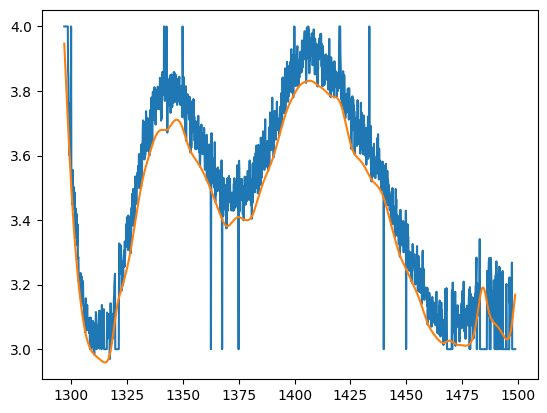

In [9]:
plt.plot(stokesi.freq, stokesi.mean(dim='time').voltages)
plt.plot(stokesi.freq, base)

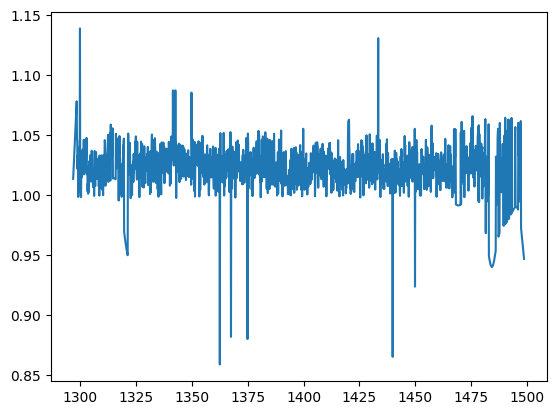

In [10]:
plt.plot(stokesi.freq, stokesi.mean(dim='time').voltages/base)
#plt.plot(stokesi.freq, base)

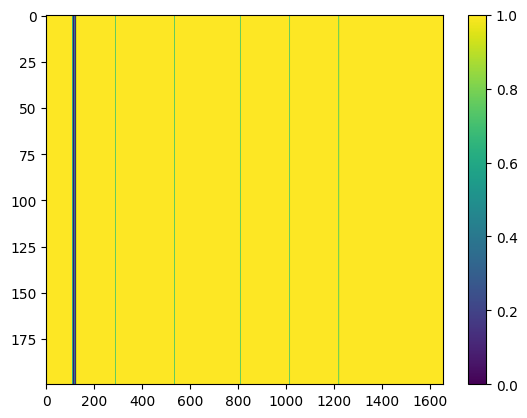

In [102]:
plt.imshow(mask_map, aspect='auto')
plt.colorbar()

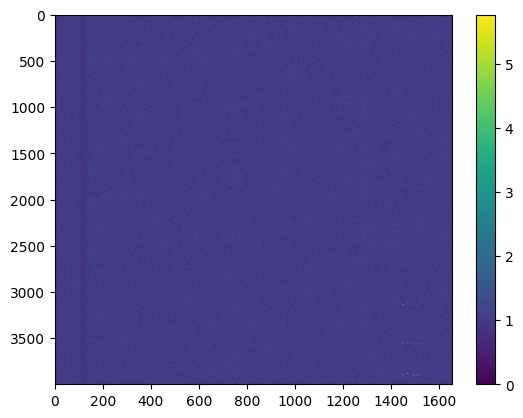

In [14]:
vmax = np.mean(stokesi.voltages) + 1*np.std(stokesi.voltages)
plt.imshow(stokesi.voltages/base, vmax=vmax, aspect='auto')
plt.colorbar()

(array([9.5540e+03, 4.6324e+04, 8.2946e+04, 7.0203e+04, 2.7571e+04,
        2.8499e+04, 3.3978e+04, 1.3839e+04, 2.6040e+03, 6.4030e+03,
        4.8190e+03, 1.4880e+03, 9.2900e+02, 6.9200e+02, 5.4800e+02,
        3.5600e+02, 2.7000e+01, 5.7000e+01, 9.6000e+01, 2.7000e+01,
        1.3000e+01, 8.0000e+00, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

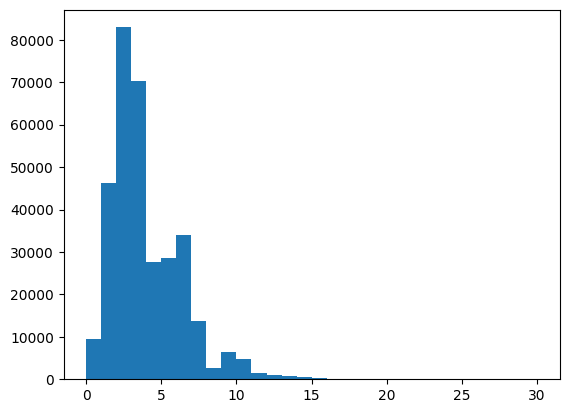

In [104]:
plt.hist(stokesi.voltages.values.ravel(), bins=30)
#plt.xlim(-1,10)

# Statistical Distribution

In [8]:
#vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240225T185734.nc') # requant = 10
#vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240225T191204.nc') # requant = 9
vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240226T180938.nc') # requant = 40
# vol = xr.open_dataset('/hdd/data/voltages/grex_dump-20240212T041511.nc') # p.33 RFI (requant=5)
nn = 24415 # 200 ms
vol = vol.isel(time=np.arange(int(16*nn), int(16*nn)+nn), freq=np.arange(255, 1910))
# calculate stokes I only from 1300 to 1500 MHz
stokesi = np.square(abs(vol), dtype='float32').sum(dim='pol', dtype='float32').sum(dim='reim', dtype='float32')
#stokesi = np.square(abs(vol.isel(freq=np.arange(255, 1910))), dtype='int32').sum(dim='pol', dtype='int32').sum(dim='reim', dtype='int32')
stokesi.to_dataarray()
vmax = np.mean(stokesi.voltages) + 2*np.std(stokesi.voltages)
#collap_t = stokesi.mean(dim='time')
dt = (stokesi.time.max().values - stokesi.time.min().values)*86400*1e3 # ms
t0 = (stokesi.time.min() - vol.time.min())*86400*1e3 # ms
print('time span of the voltage file is {:.2f} ms'.format(dt)) # seconds


time span of the voltage file is 200.00 ms


([], [])

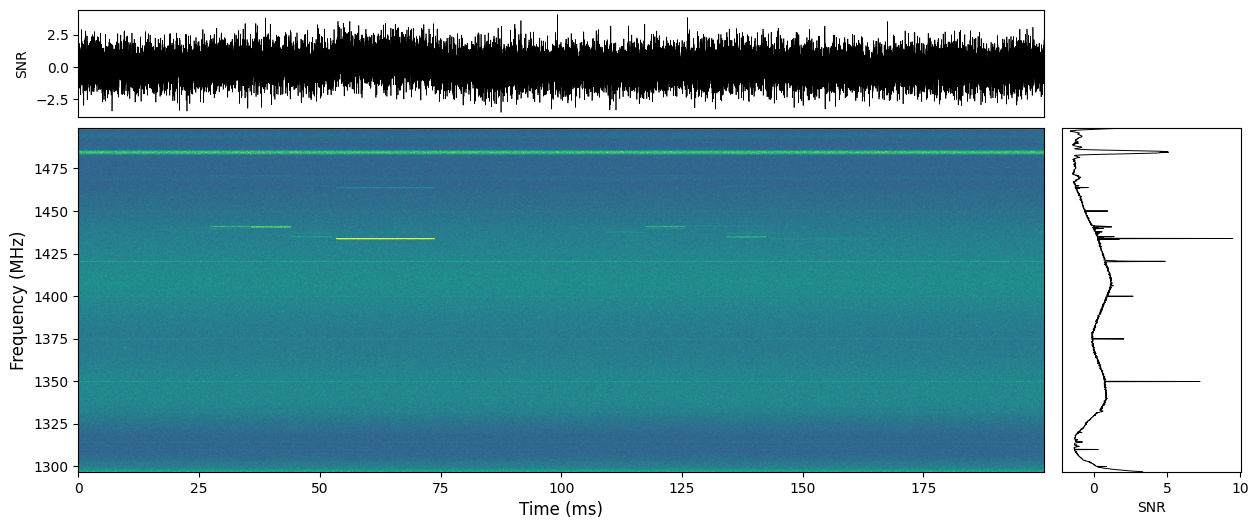

In [9]:
plt.figure(figsize=(15,6))
grid = plt.GridSpec(4, 6, wspace=0.1, hspace=0.1)

plt.subplot(grid[0, :5])
data_favg = stokesi.mean(dim='freq').voltages
plt.plot(stokesi.time, (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
# plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.xlim(stokesi.time.min(), stokesi.time.max())
plt.xticks([], [])

plt.subplot(grid[1:, :5])
vmax = np.mean(stokesi.voltages) + 2*np.std(stokesi.voltages)
plt.imshow(stokesi.voltages.T, vmax=vmax, aspect='auto', extent=(t0, dt+t0, stokesi.freq.min(), stokesi.freq.max()))
#plt.colorbar()

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Frequency (MHz)', fontsize=12)
plt.subplot(grid[1:, 5])
data_tavg = stokesi.mean(dim='time').voltages
plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), stokesi.freq, lw=0.7, color='black')# plt.xlabel('Frequency (MHz)')
# plt.ylabel('SNR')
plt.xlabel('SNR')
plt.ylim(stokesi.freq.min(), stokesi.freq.max())
plt.yticks([], [])
#plt.savefig('StokesI_before.png', dpi=600)

In [10]:
def gaussian(x, A, x0, sig):
    g = A * np.exp(-(x-x0)**2/(2*sig**2))
    return(g)

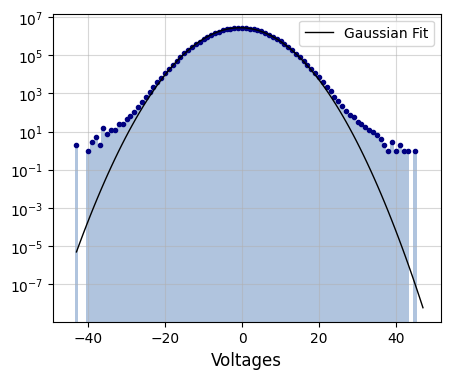

In [11]:
### before RFI cleaning
pol = 0
comp = 0 # real or imag
plt.figure(figsize=(5,4))
a = vol.voltages[:,pol,:,comp].values.min()
b = vol.voltages[:,pol,:,comp].values.max()
(hist, bin_edges) = np.histogram(vol.voltages[:,pol,:,comp].values.ravel(), bins=np.arange(a-1, b+1)-0.5)
plt.plot(bin_edges[:-1]+(np.diff(bin_edges)[0]/2), hist, 'o',ms=3, color='navy')
x = np.linspace(vol.voltages[:,pol,:,comp].values.min(),vol.voltages[:,pol,:,comp].values.max(), 100)
(f, e) = opt.curve_fit(gaussian, bin_edges[:-1]+(np.diff(bin_edges)[0]/2), hist, p0=np.array([hist.max(), -0.5, 1]), absolute_sigma=True)
plt.plot(x, gaussian(x, f[0], f[1], f[2]), color='black', lw=1, label='Gaussian Fit')
plt.hist(vol.voltages[:,pol,:,comp].values.ravel(), bins=np.arange(a-1, b+1)-0.5, color='lightsteelblue')

# plt.axvline(f[1]+3*f[2], ls=':', color='black', label='3 sig')
# plt.axvline(f[1]-3*f[2], ls=':', color='black')
plt.semilogy()
plt.xlabel('Voltages', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.5)
#plt.savefig('Histogram_vol_before_logy.png', dpi=600)

[]

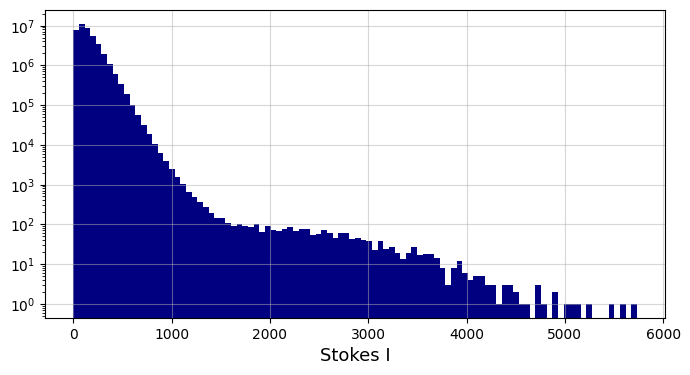

In [12]:
# plot stokes I histogram
plt.figure(figsize=(8,4))
V_sq = np.square(abs(vol), dtype='int32').sum(dim='reim', dtype='int32')
#plt.hist(stokesi.voltages.values.ravel(), bins=np.arange(stokesi.voltages.values.min(), stokesi.voltages.values.max())-0.5);
plt.hist(stokesi.voltages.values.ravel(), bins=100, color='navy');
#plt.xlim(-0.5, 50)
#plt.semilogy()
plt.xlabel('Stokes I', fontsize=13)
plt.grid(alpha=0.5)
plt.semilogy()
#plt.savefig('Histogram_stokesI_before_logy.png', dpi=600)

### after masking

<xarray.DataArray 'voltages' ()>
array(147.01755, dtype=float32)


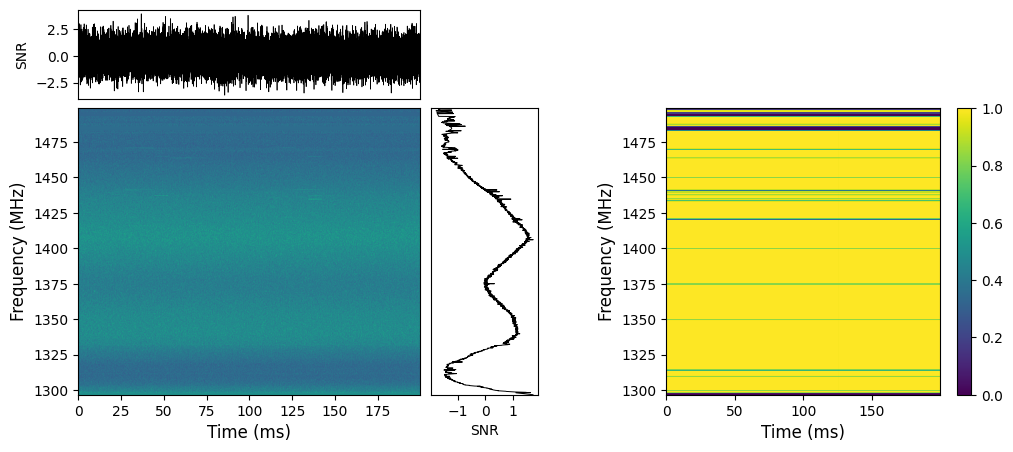

In [13]:
### after masking, see stats
#(mask_f, mask_t) = Mask(stokesi, 0.5, 4, plot=True, plot_vmax=True, return_mask=1, baseline=True, outputpng='StokesI_after.png')
(mask_f, mask_t) = Mask(stokesi, 0.5, 4, plot=True, plot_vmax=True, return_mask=1)

In [14]:
# in raw voltage file, directly remove flagged channels. 
# for a certain pol and real/imag
flag_f = np.unique(np.where(mask_f==0)[1])
test = vol.voltages[:,pol,:,comp]
test = np.delete(test, flag_f, axis=1)
print(test.shape)
# but this doesn't flag freq accordingly...
flag_t = np.unique(np.where(mask_t==0)[0])
test = np.delete(test, flag_t, axis=0)
print(test.shape)

(24415, 1556)
(24414, 1556)


[]

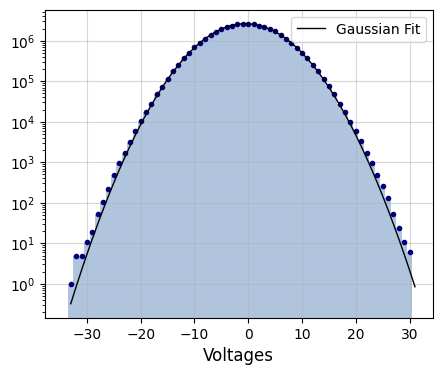

In [15]:

plt.figure(figsize=(5,4))
(hist, bin_edges) = np.histogram(test.values.ravel(), bins=np.arange(test.values.min()-1,test.values.max()+1)-0.5)
plt.plot(bin_edges[:-1]+(np.diff(bin_edges)[0]/2), hist, 'o', ms=3, color='navy')
x = np.linspace(test.values.min(),test.values.max(), 100)
(f, e) = opt.curve_fit(gaussian, bin_edges[:-1]+(np.diff(bin_edges)[0]/2), hist, p0=np.array([hist.max(), -0.5, 1]), absolute_sigma=True)
plt.plot(x, gaussian(x, f[0], f[1], f[2]), lw=1, color='black', label='Gaussian Fit')
plt.hist(test.values.ravel(), bins=np.arange(test.values.min()-1,test.values.max()+1)-0.5, color='lightsteelblue')
#plt.semilogy()
plt.xlabel('Voltages', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.5)
# plt.subplot(1,2,2)
# plt.hist(test.values.ravel(), bins=np.arange(test.values.min(),test.values.max())-0.5)
plt.semilogy()
# print('gaussian sigma = ', f[2])
#plt.savefig('Histogram_vol_after_logy_Base.png', dpi=600)

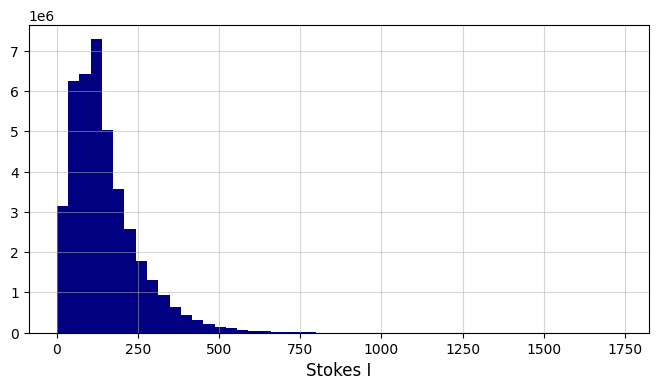

In [17]:
# plot stokes I histogram
# V_sq = np.square(abs(vol), dtype='int32').sum(dim='reim', dtype='int32')
#plt.hist(stokesi.voltages.values.ravel(), bins=np.arange(stokesi.voltages.values.min(), stokesi.voltages.values.max())-0.5);
plt.figure(figsize=(8,4))
plt.hist(stokesi.voltages.values.ravel(), bins=50, color='navy');
plt.xlabel('Stokes I', fontsize=12)
plt.grid(alpha=0.5)
#plt.semilogy()
plt.savefig('Histogram_stokesI_after_Base.png', dpi=600)

(24415,)
[   0    1    2    3    4    5    6    7    8    9  105  106  107  108
  109  110  111  112  113  114  115  116  117  118  119  120  121  122
  123  124  125  126  127  128  288  400  474  475  499  500  501  534
  639  640  641  642  643  810 1014 1015 1220 1547 1645 1646 1647 1648
 1649 1650 1651 1652 1653 1654]


Text(0.5, 0, 'Stokes I')

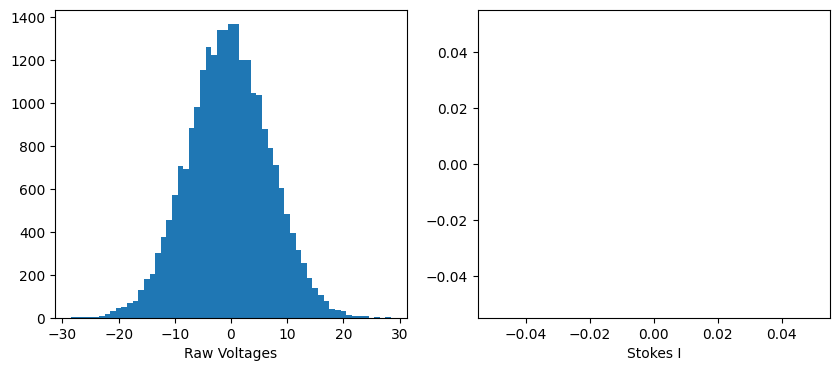

In [87]:
### check out stats for a particular freq channel
flag_f = np.unique(np.where(mask_f==0)[1])
ff = flag_f[20]
pol = 0
comp = 1
data_ff = vol.voltages[:,pol,ff,comp]
print(data_ff.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(data_ff, bins=np.arange(data_ff.min(), data_ff.max())+0.5)
plt.xlabel('Raw Voltages')
plt.subplot(1,2,2)
plt.hist(stokesi.voltages[:,ff], bins=np.arange(stokesi.voltages[:,ff].min(), stokesi.voltages[:,ff].max())+0.5);
print(flag_f)
plt.xlabel('Stokes I')

# compare distribution for "bad" freq channels and "good" ones:
# "bad" ones show larger variation, extending to larger values 
# "good" ones show smaller variation...

(1655,)


Text(0.5, 0, 'Stokes I')

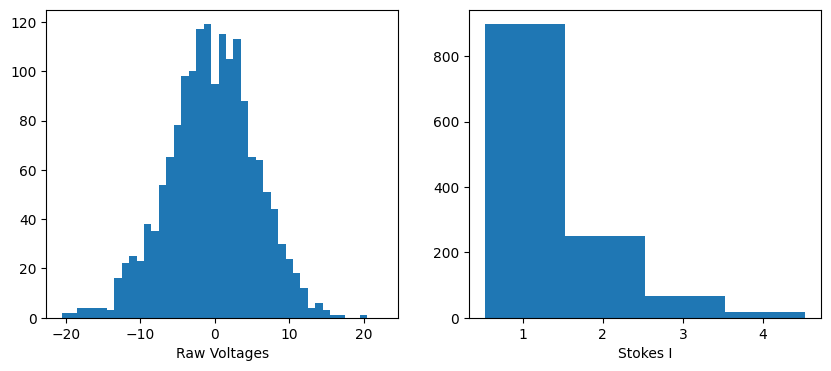

In [88]:
### time
tt = 60
pol = 0
comp = 1
data_tt = vol.voltages[tt,pol,:,comp]
print(data_tt.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(data_tt, bins=np.arange(data_tt.min(), data_tt.max())+0.5)
plt.xlabel('Raw Voltages')
plt.subplot(1,2,2)
plt.hist(stokesi.voltages[tt,:], bins=np.arange(stokesi.voltages[tt,:].min(), stokesi.voltages[tt,:].max())+0.5);
plt.xlabel('Stokes I')

In [26]:
# shift raw voltages so that it centers around 0?
test = vol.voltages+0.5

In [27]:
4.15*(1/1.28**2 - 1/1.53**2) # ms

0.7601365656471603

In [28]:
4.15e9*(1/1280**2 - 1/1530**2) # us

760.1365656471603

In [27]:
e = 4.8032e-10 #cm3/2 g1/2 s-1
me = 9.1e-28 #g
c = 3e10 # cm/s
nu = 1.4e9 #1/s
dm = 3e18 # cm^(-2)
dnu = 250e6 / 2048 # Hz
e**2/(np.pi*me*c) / nu**3 * dm * dnu # per DM

3.590013034843086e-07